In [1]:
import pandas as pd
from tqdm import tqdm
import reverse_geocoder as rg
import json
import random
import nltk
import re
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from collections import Counter
from numpy import mean
% matplotlib inline
plt.style.use('ggplot')

In [2]:
# read the entire file into a python array
# remove the trailing "\n" from each line
with open('yelp_academic_dataset_business.json') as f:
    data = [x.rstrip() for x in f.readlines()]

In [3]:
data_json_str = "[" + ','.join(data) + "]"

In [4]:
# now, load it into pandas
data_df = pd.read_json(data_json_str)

In [5]:
data_df

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,type
0,"227 E Baseline Rd, Ste J2","[BikeParking: True, BusinessAcceptsBitcoin: Fa...",0DI8Dt2PJp07XkVvIElIcQ,"[Tobacco Shops, Nightlife, Vape Shops, Shopping]",Tempe,"[Monday 11:0-21:0, Tuesday 11:0-21:0, Wednesda...",0,33.378214,-111.936102,Innovative Vapors,,85283,17,4.5,AZ,business
1,495 S Grand Central Pkwy,"[BusinessAcceptsBitcoin: False, BusinessAccept...",LTlCaCGZE14GuaUXUGbamg,"[Caterers, Grocery, Food, Event Planning & Ser...",Las Vegas,"[Monday 0:0-0:0, Tuesday 0:0-0:0, Wednesday 0:...",1,36.192284,-115.159272,Cut and Taste,,89106,9,5.0,NV,business
2,979 Bloor Street W,"[Alcohol: none, Ambience: {'romantic': False, ...",EDqCEAGXVGCH4FJXgqtjqg,"[Restaurants, Pizza, Chicken Wings, Italian]",Toronto,"[Monday 11:0-2:0, Tuesday 11:0-2:0, Wednesday ...",1,43.661054,-79.429089,Pizza Pizza,Dufferin Grove,M6H 1L5,7,2.5,ON,business
3,7014 Steubenville Pike,"[AcceptsInsurance: False, BusinessAcceptsCredi...",cnGIivYRLxpF7tBVR_JwWA,"[Hair Removal, Beauty & Spas, Blow Dry/Out Ser...",Oakdale,"[Tuesday 10:0-21:0, Wednesday 10:0-21:0, Thurs...",1,40.444544,-80.174540,Plush Salon and Spa,,15071,4,4.0,PA,business
4,321 Jarvis Street,"[BusinessAcceptsCreditCards: True, Restaurants...",cdk-qqJ71q6P7TJTww_DSA,"[Hotels & Travel, Event Planning & Services, H...",Toronto,None,1,43.659829,-79.375401,Comfort Inn,Downtown Core,M5B 2C2,8,3.0,ON,business
5,"30 Gibson Drive, Suite122","[BusinessAcceptsCreditCards: True, ByAppointme...",Q9rsaUiQ-A3NdEAloy0aJA,"[Nail Salons, Beauty & Spas]",Markham,"[Monday 10:30-20:0, Tuesday 10:30-20:0, Thursd...",1,43.827640,-79.342722,A Plus Nail,,L3R 2S3,3,2.5,ON,business
6,10875 N Frankloyd Wright Blvd,"[BikeParking: True, BusinessAcceptsCreditCards...",Cu4_Fheh7IrzGiK-Pc79ig,"[Baby Gear & Furniture, Shopping]",Scottsdale,"[Monday 10:0-18:0, Tuesday 10:0-18:0, Wednesda...",1,33.585271,-111.834954,Boomerang Baby,,85259,8,3.5,AZ,business
7,11072 No Frank Lloyd Wright,"[Alcohol: none, Ambience: {'romantic': False, ...",GDnbt3isfhd57T1QqU6flg,"[Tex-Mex, Mexican, Fast Food, Restaurants]",Scottsdale,"[Monday 10:0-22:0, Tuesday 10:0-22:0, Wednesda...",1,33.586710,-111.835410,Taco Bell,,85259,9,2.5,AZ,business
8,11000 North 115th Street,[BusinessAcceptsCreditCards: True],qwAHit4Tuj1zpO7CxVwOMA,"[Local Services, Self Storage]",Scottsdale,"[Monday 9:30-18:0, Tuesday 9:30-18:0, Wednesda...",1,33.586440,-111.832579,CubeSmart Self Storage,,85259,11,4.5,AZ,business
9,Hauptstr. 1,"[BikeParking: True, BusinessAcceptsCreditCards...",Nbr0kbtIrVlEcKIZoXWbSw,"[Food, Bakeries]",Stuttgart,None,1,48.729900,9.112420,Sehne Backwaren,,70563,3,3.5,BW,business


In [6]:
# get country of all businesses based on their geographical location
coords = [(data_df.latitude[i],data_df.longitude[i]) for i in tqdm(range(data_df.shape[0]))]
results = rg.search(coords)
# filter to keep only US based business ids
USbiz = [res['cc']=='US' for res in results]
# create a set of unique business ids in the US for fast lookup
USids = set(data_df.business_id[pd.Series(USbiz)])

100%|██████████| 144072/144072 [00:03<00:00, 39388.26it/s]


Loading formatted geocoded file...


In [7]:
random.seed(1234)

In [8]:
# Read 85% of the lines and filter to keep only those which are in the US
lines = [line.rstrip() for line in tqdm(open('yelp_academic_dataset_review.json')) if (random.random() >= 0.85 and (json.loads(line)['business_id'] in USids))]

4153150it [00:11, 361750.71it/s]


In [9]:
len(lines)

517191

In [17]:
random.choice(lines)

'{"review_id":"9KiBRzRoIwy2I_TKrdlAXg","user_id":"pAk_PwUs6zawd2rW01-RNg","business_id":"Gen0ei06dGq13OJ8DRXUjg","stars":4,"date":"2014-09-22","text":"I am from New York & I have tasted some amazing pizza! This pizza here is very good. Not compared to New York but it is better than most pizza\'s in Las Vegas.","useful":1,"funny":0,"cool":0,"type":"review"}'

In [18]:
# convert the chosen lines to a single json string and read it into a pandas dataframe
data_json_str = "[" + ','.join(lines) + "]"
data_df = pd.read_json(data_json_str)
data_df

,business_id,cool,date,funny,review_id,stars,text,type,useful,user_id
0,2aFiy99vNLklCx3T_tGS9A,0,2011-10-10,0,NxL8SIC5yqOdnlXCg18IBg,5,If you enjoy service by someone who is as comp...,review,0,KpkOkG6RIf4Ra25Lhhxf1A
1,2LfIuF3_sX6uwe-IR-P0jQ,1,2014-07-14,0,GP6YEearUWrzPtQYSF1vVg,5,Highly recommended. Went in yesterday looking ...,review,0,aW3ix1KNZAvoM8q-WghA3Q
2,2LfIuF3_sX6uwe-IR-P0jQ,0,2014-01-15,0,25RlYGq2s5qShi-pn3ufVA,4,I walked in here looking for a specific piece ...,review,0,YOo-Cip8HqvKp_p9nEGphw
3,0czfEgv9KAD4VlIa7ANPWQ,0,2009-01-30,0,5hU8Uxdem1j_PEr4HFs5HQ,5,I read the reviewer before me and checked thin...,review,0,9Cmmt_34PxuC84P1AgmetQ
4,4P-vTvE6cncJyUyLh73pxw,0,2012-10-20,0,8Mu56iQ-MYEyivqUVss0XA,4,"Don't go here for the decor, but the staff is ...",review,1,SYKPwRhnlKrW6yTvm7oPWg
5,4P-vTvE6cncJyUyLh73pxw,0,2011-04-01,2,Pqe0NlNUcxzEnUXALZviuA,3,The food is typical. Wait how much was my mea...,review,0,1-xPzJk_ijBvY2J8Re1DIQ
6,4P-vTvE6cncJyUyLh73pxw,1,2013-04-01,1,sKStdKdvO5nIn1ZN0OC-cg,2,Not particularly good. Bathroom is nasty. Food...,review,2,bZBPVRIGQZ0WXRYLtYXbYQ
7,4uiijOUDzc-DeIb2XcKW_A,2,2010-09-06,1,N42b2u6YSL5iEjN6NnrKeQ,4,My boyfriend and I decided to go resturant hun...,review,2,GDeoUHALgyqK13ewN92Jnw
8,4uiijOUDzc-DeIb2XcKW_A,0,2011-03-18,0,3oy99xSSdewIQxS3Vc4M6A,3,"The restaurant was pretty slick, great atmosph...",review,0,c3oKqsoDC9SDjJjP1LMARA
9,4uiijOUDzc-DeIb2XcKW_A,0,2010-02-22,0,HTolWbNJUULt5u_bWne1IQ,2,The best description I can give about this res...,review,1,E5glLZ1mCo10-zqq3Bj13w


In [19]:
# Drop unused columns from the dataframe
data_df.drop(['review_id', 'user_id', 'date', 'cool', 'funny', 'useful', 'type'], axis=1, inplace=True)

In [20]:
data_df

,business_id,stars,text
0,2aFiy99vNLklCx3T_tGS9A,5,If you enjoy service by someone who is as comp...
1,2LfIuF3_sX6uwe-IR-P0jQ,5,Highly recommended. Went in yesterday looking ...
2,2LfIuF3_sX6uwe-IR-P0jQ,4,I walked in here looking for a specific piece ...
3,0czfEgv9KAD4VlIa7ANPWQ,5,I read the reviewer before me and checked thin...
4,4P-vTvE6cncJyUyLh73pxw,4,"Don't go here for the decor, but the staff is ..."
5,4P-vTvE6cncJyUyLh73pxw,3,The food is typical. Wait how much was my mea...
6,4P-vTvE6cncJyUyLh73pxw,2,Not particularly good. Bathroom is nasty. Food...
7,4uiijOUDzc-DeIb2XcKW_A,4,My boyfriend and I decided to go resturant hun...
8,4uiijOUDzc-DeIb2XcKW_A,3,"The restaurant was pretty slick, great atmosph..."
9,4uiijOUDzc-DeIb2XcKW_A,2,The best description I can give about this res...


### Abandoned idea of balancing number of reviews for each class

### Analysis resumed

In [21]:
revs = data_df.text
stars = data_df.stars

In [22]:
revs.head()

0    If you enjoy service by someone who is as comp...
1    Highly recommended. Went in yesterday looking ...
2    I walked in here looking for a specific piece ...
3    I read the reviewer before me and checked thin...
4    Don't go here for the decor, but the staff is ...
Name: text, dtype: object

In [23]:
stars.value_counts().sort_index()

1     70388
2     43294
3     59127
4    120834
5    223548
Name: stars, dtype: int64

In [24]:
stars.value_counts()[3]

59127

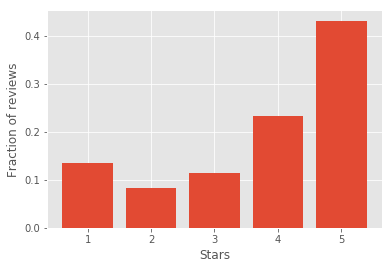

In [25]:
Xs = stars.value_counts().sort_index().index
Ys = [stars.value_counts()[key]/len(revs) for key in Xs]
plt.xlabel('Stars')
plt.ylabel('Fraction of reviews')
plt.bar(Xs, Ys)
plt.savefig('star_hist.png',bbox_inches='tight', dpi=150)

273


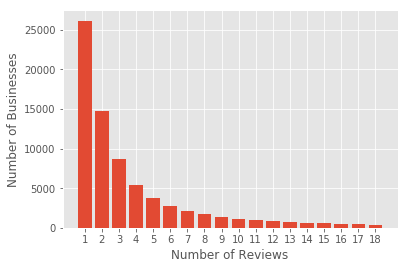

In [26]:
num_reviews = Counter(data_df.business_id.value_counts())
print(len(num_reviews))
Xs = [x[0] for x in num_reviews.most_common()]
Ys = [x[1] for x in num_reviews.most_common()]
Xs = Xs[:18]
Ys = Ys[:18]
plt.bar(Xs, Ys)
plt.xticks(range(1,19))
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Businesses")
plt.savefig('numrev_hist.png',bbox_inches='tight', dpi=150)

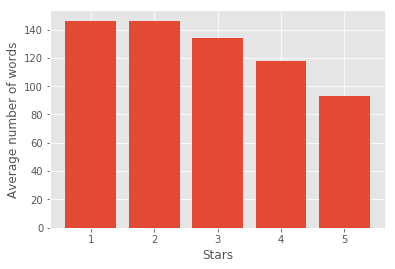

In [27]:
num_words = data_df.groupby('stars').text.apply(lambda x: mean(x.apply(lambda y: len(y.split()))))
plt.xlabel('Stars')
plt.ylabel('Average number of words')
plt.bar(num_words.index, num_words.values)
plt.savefig('words_hist.png',bbox_inches='tight', dpi=150)

## The following few lines are testing various methods to get the optimal performance

In [29]:
%timeit ' '.join([stemmer(word) for word in regex.sub('' ,'The vintage 1930 beaded earrings are still calling to me.').split()])

51.6 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [30]:
%timeit ' '.join(map(stemmer,regex.sub('','The vintage 1930 beaded earrings are still calling to me.').split()))

57 µs ± 8.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
import functools
L = ['Testing', 'shows', 'the', 'presence', ',','not', 'the', 'absence', 'of', 'bugs']

In [32]:
%timeit functools.reduce( (lambda x,y:x+' '+y), L)

2.22 µs ± 606 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [33]:
%timeit ' '.join(L)

217 ns ± 69.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [34]:
%timeit re.sub('[^a-z ]+','','hello 1923worl 234 shad54awo')

2.99 µs ± 868 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
regex = re.compile('[^A-Za-z ]+')

In [36]:
%timeit regex.sub('','hello 1923worl 234 shad54awo')

3.54 µs ± 918 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [37]:
# based on http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html

stemmer = SnowballStemmer("english", ignore_stopwords=True).stem
regex = re.compile('[^A-Za-z ]+')

# first attempt - very slow
def tokenize(text):
    regex = re.compile('[^a-z]')
    tokens = nltk.word_tokenize(regex.sub(' ', ''.join(text)))
    #tokens = [i for i in tokens if (i not in string.punctuation and len(i)>1)]
    tokens = [i for i in tokens if (len(i)>1)]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(item) for item in tokens]
    return stems

# second attempt - a bit faster - using custom preprocessor for stemming
def prepro(text):
    #return PorterStemmer().stem(re.sub(r'[^a-z ]+','',text)) #fast but does not do stemming
    
    #return ' '.join([PorterStemmer().stem(word) for word in re.sub('[^a-z ]+','',text).split()])
    
    #using map is faster than list comprehension
    #return ' '.join(map(stemmer, re.sub('[^a-z ]+','',text).split())) 
    
    #using pre-compiled regex is faster
    return ' '.join(map(stemmer, regex.sub('',text).split()))


# fastest method - use custom preprocessor and modified analyzer function for stemming
def prepro2(text):
    return regex.sub('',text)

In [38]:
# import and instantiate TfidfVectorizer (with custom parameters to remove rare words)
from sklearn.feature_extraction.text import TfidfVectorizer
# learn the 'vocabulary' of the training data (occurs in-place)

# compare using custom tokenizer and preprocessor - preprocessor is faster
# tfvect = TfidfVectorizer(stop_words='english', tokenizer=tokenize, max_df=0.75)

tfvect = TfidfVectorizer(stop_words='english', preprocessor=prepro, max_df=0.75, min_df=2, max_features=5000)

## Analysis resumes from here

In [39]:
# Build my own class for TfidfVectorizer which also does stemming

class StemmedTfidfVectorizer(TfidfVectorizer):
    stemmer = SnowballStemmer("english", ignore_stopwords=True).stem
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([self.stemmer(w) for w in analyzer(doc)])

stfvect = StemmedTfidfVectorizer(stop_words='english', preprocessor=prepro2, max_df=0.75, min_df=2, max_features=5000)

In [40]:
%time headdtm = tfvect.fit_transform(revs.head(20000)) #Time comparison

CPU times: user 17.4 s, sys: 43.1 ms, total: 17.5 s
Wall time: 17.5 s


In [41]:
%time headdtm2 = stfvect.fit_transform(revs.head(20000))

CPU times: user 24 s, sys: 30.7 ms, total: 24 s
Wall time: 24.2 s


In [42]:
stfvect.get_feature_names()

['aaa',
 'aaron',
 'ab',
 'abandon',
 'abil',
 'abl',
 'about',
 'absolut',
 'absurd',
 'abund',
 'abus',
 'ac',
 'accent',
 'accept',
 'access',
 'accessori',
 'accid',
 'accident',
 'accommod',
 'accomod',
 'accompani',
 'accomplish',
 'accord',
 'account',
 'accur',
 'ace',
 'ach',
 'achiev',
 'acid',
 'acknowledg',
 'acryl',
 'act',
 'action',
 'activ',
 'actor',
 'actual',
 'acupunctur',
 'ad',
 'adam',
 'add',
 'addict',
 'addit',
 'address',
 'adequ',
 'adjac',
 'adjust',
 'admir',
 'admiss',
 'admit',
 'adobo',
 'adopt',
 'ador',
 'adorn',
 'adult',
 'advanc',
 'advantag',
 'adventur',
 'advertis',
 'advic',
 'advis',
 'aesthet',
 'affair',
 'affect',
 'afford',
 'aforement',
 'afraid',
 'african',
 'after',
 'afternoon',
 'afterward',
 'again',
 'age',
 'agenc',
 'agent',
 'aggress',
 'ago',
 'agre',
 'agreement',
 'ah',
 'ahead',
 'ahi',
 'ahold',
 'ahwatuke',
 'aid',
 'aint',
 'aioli',
 'air',
 'airi',
 'airlin',
 'airport',
 'aisl',
 'aj',
 'aka',
 'al',
 'ala',
 'alarm',
 

In [43]:
# examine the removed stop words including the data driven stop words
stfvect.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [44]:
len(stfvect.get_stop_words())

318

In [45]:
stars.value_counts()

5    223548
4    120834
1     70388
3     59127
2     43294
Name: stars, dtype: int64

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(revs, stars, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(387893,)
(129298,)
(387893,)
(129298,)


In [47]:
# Calculating null accuracy
y_test.value_counts().head(1)/y_test.shape

5    0.431824
Name: stars, dtype: float64

In [48]:
%time X_train_dtm = stfvect.fit_transform(X_train)

CPU times: user 4min 43s, sys: 365 ms, total: 4min 44s
Wall time: 4min 44s


In [49]:
stfvect.get_feature_names()

['aaa',
 'aaron',
 'abil',
 'abl',
 'about',
 'absolut',
 'absurd',
 'abund',
 'abus',
 'ac',
 'acai',
 'accent',
 'accept',
 'access',
 'accessori',
 'accid',
 'accident',
 'accommod',
 'accomod',
 'accompani',
 'accomplish',
 'accord',
 'account',
 'accur',
 'accus',
 'accustom',
 'ace',
 'ach',
 'achiev',
 'acid',
 'acknowledg',
 'acoust',
 'acrobat',
 'acryl',
 'act',
 'action',
 'activ',
 'actor',
 'actual',
 'ad',
 'adam',
 'add',
 'addict',
 'addit',
 'address',
 'adequ',
 'adjac',
 'adjust',
 'admir',
 'admiss',
 'admit',
 'adobo',
 'adopt',
 'ador',
 'adult',
 'advanc',
 'advantag',
 'adventur',
 'advertis',
 'advic',
 'advis',
 'advisor',
 'aesthet',
 'affect',
 'afford',
 'aforement',
 'afraid',
 'after',
 'afternoon',
 'afterward',
 'again',
 'age',
 'agenc',
 'agent',
 'aggress',
 'ago',
 'agre',
 'agreement',
 'ah',
 'ahead',
 'ahi',
 'ahwatuke',
 'aid',
 'aim',
 'aint',
 'aioli',
 'air',
 'airi',
 'airlin',
 'airport',
 'aisl',
 'aj',
 'aka',
 'al',
 'ala',
 'alarm',
 'a

In [50]:
# transform test data (using fitted vocabulary in stfvec) into a document-term matrix
X_test_dtm = stfvect.transform(X_test)
X_test_dtm

<129298x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 5438918 stored elements in Compressed Sparse Row format>

In [51]:
# import and instantiate MultinomialNB
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [52]:
# train the model using X_train_dtm
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [53]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.58845457779702703

In [54]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[12225,  1254,   401,  1262,  2367],
       [ 3078,  1161,  1223,  3185,  2237],
       [ 1277,   351,  1194,  7937,  3968],
       [  765,    60,   220, 14235, 15064],
       [ 1010,     6,    34,  7513, 47271]])

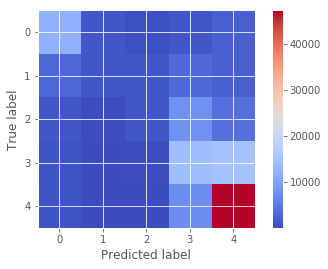

In [55]:
plt.imshow(metrics.confusion_matrix(y_test, y_pred_class), cmap="coolwarm", interpolation="None")
plt.colorbar()
plt.xlabel("Predicted label")
plt.xticks(range(5))
plt.yticks(range(5))
plt.ylabel("True label")
plt.savefig('nb_conf.png',bbox_inches='tight', dpi=150)

In [56]:
# print the classification report
print(metrics.classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          1       0.67      0.70      0.68     17509
          2       0.41      0.11      0.17     10884
          3       0.39      0.08      0.13     14727
          4       0.42      0.47      0.44     30344
          5       0.67      0.85      0.75     55834

avg / total       0.55      0.59      0.55    129298



In [57]:
# Try logistic regression for classification
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(Cs=5, n_jobs=-1, random_state=42)

In [58]:
lr.fit(X_train_dtm, y_train)

LogisticRegressionCV(Cs=5, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [59]:
# make class predictions for X_test_dtm
y_pred_class = lr.predict(X_test_dtm)
# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_class)

0.64168045909449489

In [60]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[14830,     8,   933,   532,  1206],
       [ 4665,    20,  3420,  1659,  1120],
       [ 1460,    19,  5108,  5808,  2332],
       [  589,     8,  1769, 14283, 13695],
       [  567,     7,   368,  6165, 48727]])

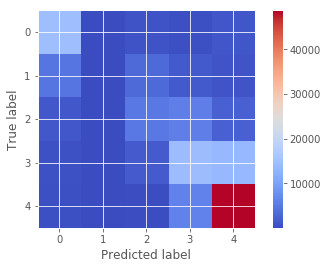

In [61]:
plt.imshow(metrics.confusion_matrix(y_test, y_pred_class), cmap="coolwarm", interpolation="None")
plt.colorbar()
plt.xlabel("Predicted label")
plt.xticks(range(5))
plt.yticks(range(5))
plt.ylabel("True label")
plt.savefig('lr_conf.png',bbox_inches='tight', dpi=150)

In [62]:
# print the classification report
print(metrics.classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          1       0.67      0.85      0.75     17509
          2       0.32      0.00      0.00     10884
          3       0.44      0.35      0.39     14727
          4       0.50      0.47      0.49     30344
          5       0.73      0.87      0.79     55834

avg / total       0.60      0.64      0.60    129298



## Inspection of only 5 star and 1 star reviews to get the most predictive tokens

In [63]:
# Make a new dataframe with only 1 star and 5 star reviews
best_worst = data_df.loc[(stars==5) | (stars==1), :]
best_worst.head()

,business_id,stars,text
0,2aFiy99vNLklCx3T_tGS9A,5,If you enjoy service by someone who is as comp...
1,2LfIuF3_sX6uwe-IR-P0jQ,5,Highly recommended. Went in yesterday looking ...
3,0czfEgv9KAD4VlIa7ANPWQ,5,I read the reviewer before me and checked thin...
10,32S_SP-ZaVmQucdEY5ynlQ,1,No way would I live here again! This is not a...
13,1Lbq92b6B9z1FYk5mS2R9Q,1,"Nasty, terrible and disgusting come to mind as..."


In [64]:
# Perform train-test split again as before
X = best_worst.text
y = best_worst.stars
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

# fit and transform X_train into X_train_dtm using the stemmed tfidf vectorizer created earlier
X_train_dtm = stfvect.fit_transform(X_train)
X_train.shape

(220452,)

In [65]:
# Similarly transform the test reviews with the same fitted stfvect
X_test_dtm = stfvect.transform(X_test)
X_test_dtm.shape

(73484, 5000)

In [66]:
# fit multinomial NB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

In [67]:
# store the vocabulary of X_train
X_train_tokens = stfvect.get_feature_names()
len(X_train_tokens)

5000

In [68]:
X_train_tokens

['aaa',
 'aaron',
 'abil',
 'abl',
 'about',
 'absolut',
 'absurd',
 'abund',
 'abus',
 'ac',
 'acai',
 'accent',
 'accept',
 'access',
 'accessori',
 'accid',
 'accident',
 'accommod',
 'accomod',
 'accompani',
 'accomplish',
 'accord',
 'account',
 'accur',
 'accus',
 'ace',
 'ach',
 'achiev',
 'acid',
 'acknowledg',
 'acrobat',
 'acryl',
 'act',
 'action',
 'activ',
 'actor',
 'actual',
 'acura',
 'ad',
 'adam',
 'add',
 'addict',
 'addit',
 'address',
 'adequ',
 'adjac',
 'adjust',
 'admir',
 'admiss',
 'admit',
 'adobada',
 'adopt',
 'ador',
 'adult',
 'advanc',
 'advantag',
 'adventur',
 'advertis',
 'advic',
 'advis',
 'advisor',
 'aesthet',
 'affair',
 'affect',
 'afford',
 'afraid',
 'african',
 'after',
 'afternoon',
 'afterward',
 'again',
 'againi',
 'age',
 'agenc',
 'agent',
 'aggrav',
 'aggress',
 'ago',
 'agre',
 'agreement',
 'ah',
 'ahead',
 'ahi',
 'ahwatuke',
 'aid',
 'aint',
 'aioli',
 'air',
 'airi',
 'airlin',
 'airport',
 'aisl',
 'aj',
 'aka',
 'al',
 'ala',
 '

In [69]:
# store the number of times each token appears across each class
one_star_token_count = nb.feature_count_[0, :]
five_star_token_count = nb.feature_count_[1, :]

In [70]:
# create a DataFrame of tokens with their separate one-star and five-star counts
tokens = pd.DataFrame({'token':X_train_tokens, 'one_star':one_star_token_count, 'five_star':five_star_token_count}).set_index('token')

In [71]:
tokens.head(10)

,five_star,one_star
token,,
aaa,29.780911,11.663859
aaron,48.722618,3.650333
abil,68.242193,20.621758
abl,789.982532,162.148005
about,44.274823,42.463928
absolut,1198.933369,262.730817
absurd,6.571552,20.660469
abund,39.712716,7.442733
abus,8.614079,21.585826


In [72]:
# add 1 to one-star and five-star counts to avoid dividing by 0 when calculating ratio of counts
tokens['one_star'] = tokens.one_star + 1
tokens['five_star'] = tokens.five_star + 1

In [73]:
# first number is one-star reviews, second number is five-star reviews
nb.class_count_

array([  52776.,  167676.])

In [74]:
# converting the one-star and five-star counts into frequencies
tokens['one_star'] = tokens.one_star / nb.class_count_[0]
tokens['five_star'] = tokens.five_star / nb.class_count_[1]

In [75]:
# calculate the ratio of five-star to one-star for each token
tokens['five_star_ratio'] = tokens.five_star / tokens.one_star

In [76]:
# sort the DataFrame by five_star_ratio (descending order), and examine the first 10 rows
tokens.sort_values('five_star_ratio', ascending=False).head(10)

,five_star,one_star,five_star_ratio
token,,,
delici,0.015994,0.000708,22.588535
gem,0.002757,0.000133,20.803185
yum,0.002358,0.000118,20.015850
fantast,0.008154,0.000415,19.650370
delish,0.001355,0.000070,19.452288
superb,0.001567,0.000088,17.888720
notch,0.002526,0.000141,17.870888
outstand,0.003782,0.000220,17.198902
cozi,0.001397,0.000082,16.944230


In [77]:
# sort the DataFrame by five_star_ratio (ascending order), and examine the first 10 rows
tokens.sort_values('five_star_ratio', ascending=True).head(10)

,five_star,one_star,five_star_ratio
token,,,
unprofession,0.000033,0.004489,0.007414
unaccept,0.000015,0.001544,0.009713
rudest,0.000009,0.000901,0.009953
unhelp,0.000011,0.000908,0.011887
ined,0.000016,0.001300,0.011952
incompet,0.000020,0.001696,0.011999
worst,0.000224,0.017254,0.012978
disrespect,0.000023,0.001750,0.013010
uneth,0.000008,0.000535,0.015229
